# Decision Trees and Random Forests in Python

## Import Libraries

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [42]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true))* 100

In [43]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    logloss = log_loss(y_train,predictProba)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'logloss': logloss
    }
    
def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    logloss = log_loss(y_test,predictProba)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'logloss': logloss
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [44]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [45]:
def calculate_threshold(model, base_data, flag_data):
    probs = model.predict_proba(base_data)
    preds = probs[:,1]
    fpr, tpr, thresholds =roc_curve(flag_data, preds)
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)

    ####################################
    # The optimal cut off would be where tpr is high and fpr is low
    # tpr - (1-fpr) is zero or near to zero is the optimal cut off point
    ####################################
    i = np.arange(len(tpr)) # index for df
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
    thres = roc.iloc[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    return thres

## Get the Data

In [2]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [3]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## EDA

We'll just check out a simple pairplot for this small dataset.

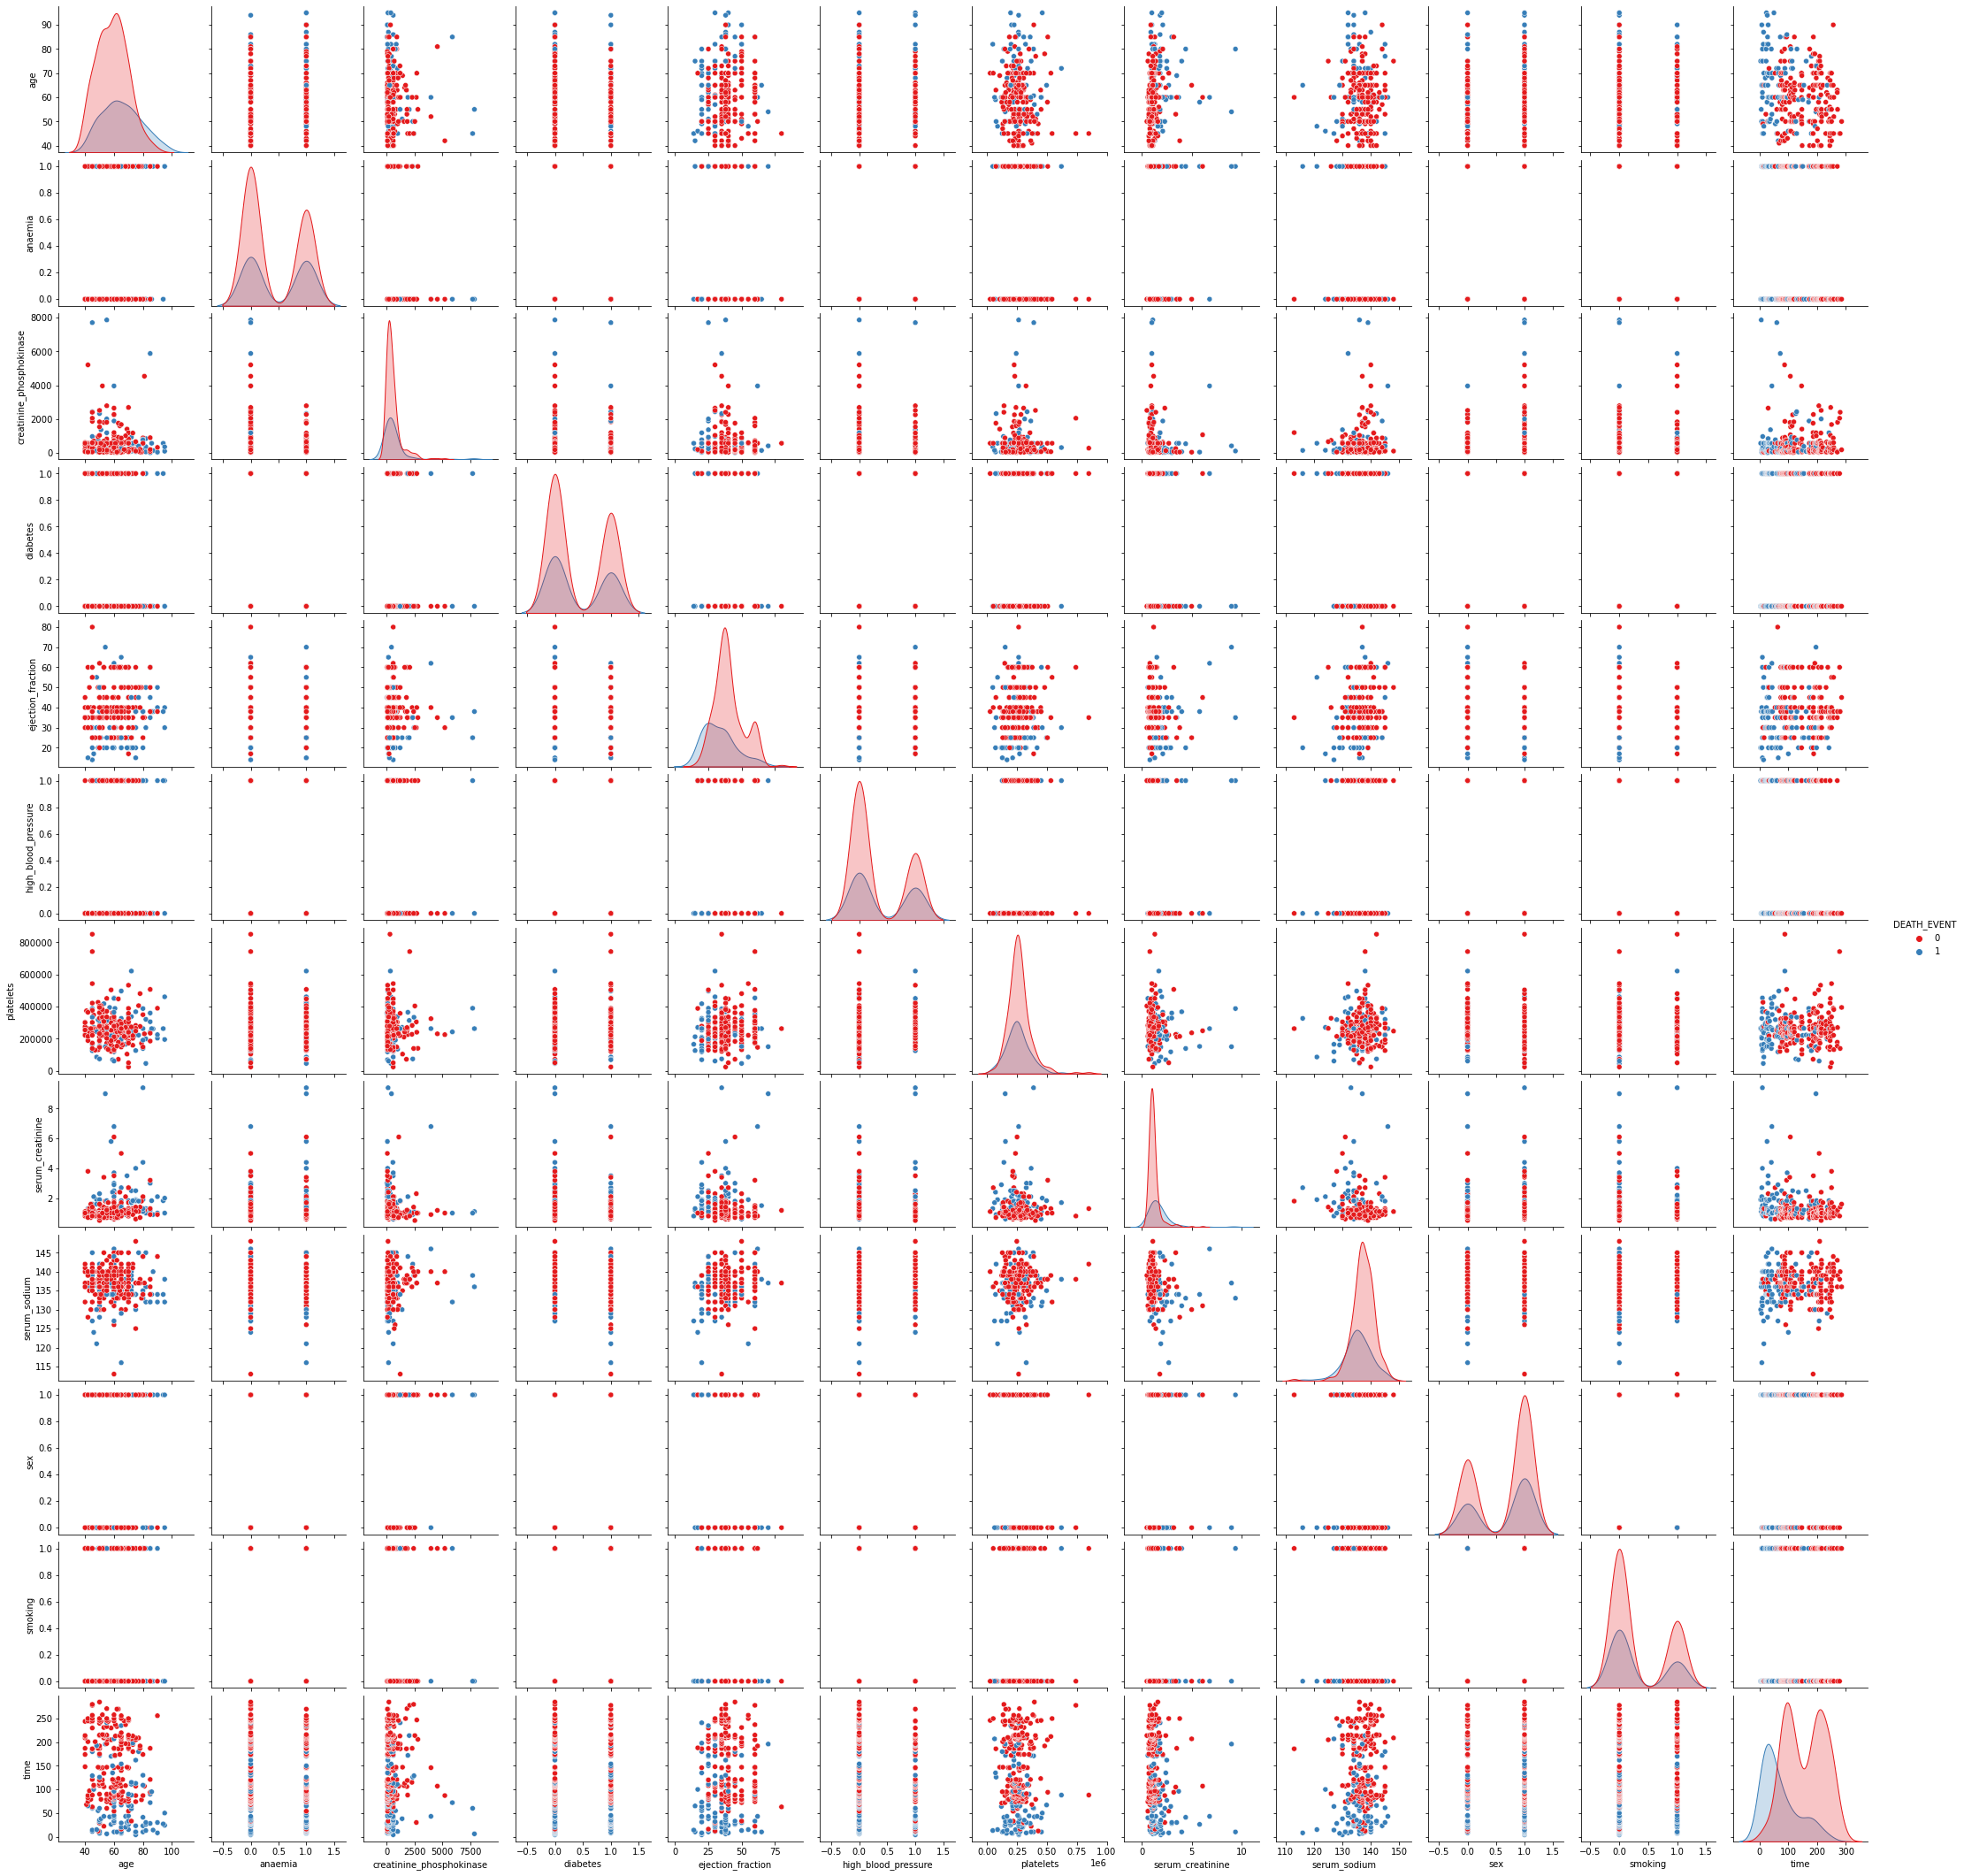

In [4]:
sns.pairplot(df,hue='DEATH_EVENT',palette='Set1')

In [37]:
df.corr()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
age,1.000000,0.088006,-0.081584,-0.101012,0.060098,0.093289,-0.052354,0.159187,-0.045966,0.065430,0.018668,-0.224068,0.253729
anaemia,0.088006,1.000000,-0.190741,-0.012729,0.031557,0.038182,-0.043786,0.052174,0.041882,-0.094769,-0.107290,-0.141414,0.066270
creatinine_phosphokinase,-0.081584,-0.190741,1.000000,-0.009639,-0.044080,-0.070590,0.024463,-0.016408,0.059550,0.079791,0.002421,-0.009346,0.062728
diabetes,-0.101012,-0.012729,-0.009639,1.000000,-0.004850,-0.012732,0.092193,-0.046975,-0.089551,-0.157730,-0.147173,0.033726,-0.001943
ejection_fraction,0.060098,0.031557,-0.044080,-0.004850,1.000000,0.024445,0.072177,-0.011302,0.175902,-0.148386,-0.067315,0.041729,-0.268603
high_blood_pressure,0.093289,0.038182,-0.070590,-0.012732,0.024445,1.000000,0.049963,-0.004935,0.037109,-0.104615,-0.055711,-0.196439,0.079351
platelets,-0.052354,-0.043786,0.024463,0.092193,0.072177,0.049963,1.000000,-0.041198,0.062125,-0.125120,0.028234,0.010514,-0.049139
serum_creatinine,0.159187,0.052174,-0.016408,-0.046975,-0.011302,-0.004935,-0.041198,1.000000,-0.189095,0.006970,-0.027414,-0.149315,0.294278
serum_sodium,-0.045966,0.041882,0.059550,-0.089551,0.175902,0.037109,0.062125,-0.189095,1.000000,-0.027566,0.004813,0.087640,-0.195204
sex,0.065430,-0.094769,0.079791,-0.157730,-0.148386,-0.104615,-0.125120,0.006970,-0.027566,1.000000,0.445892,-0.015608,-0.004316


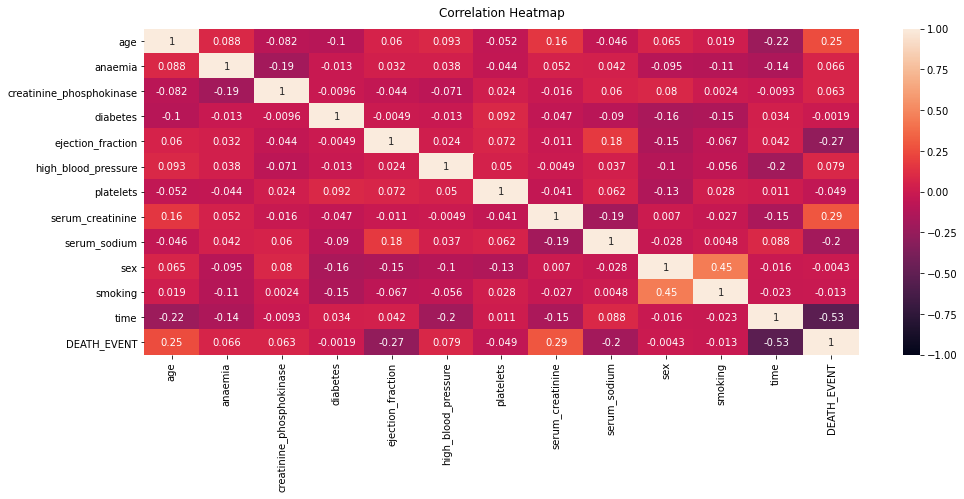

In [40]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Train Test Split

Let's split up the data into a training set and a test set!

In [5]:
from sklearn.model_selection import train_test_split

In [10]:
X = df.drop('DEATH_EVENT',axis=1)
y = df['DEATH_EVENT']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=y, random_state=42)

## Decision Trees

We'll start just by training a single decision tree.

In [50]:
from sklearn.tree import DecisionTreeClassifier

In [66]:
dtree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, 
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                               random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                               min_impurity_split=None, class_weight=None, ccp_alpha=0.0)

In [67]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

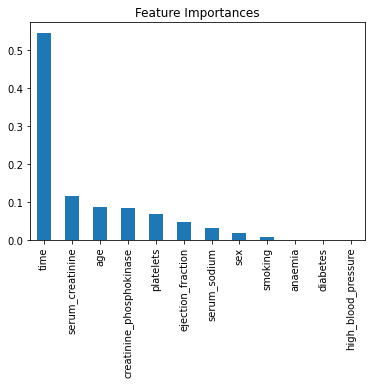

In [82]:
coef1 = pd.Series(dtree.feature_importances_, X_train.columns).sort_values(ascending = False)
coef1.iloc[:20].plot(kind='bar', title='Feature Importances')

In [84]:
feature_importances = dtree.feature_importances_
feature_list = list(X)
relative_importances = pd.DataFrame(index = feature_list, data = feature_importances, columns = ['importance'])
relative_importances.sort_values(by = 'importance', ascending = False)

,importance
time,0.545955
serum_creatinine,0.113883
age,0.086092
creatinine_phosphokinase,0.083958
platelets,0.068251
ejection_fraction,0.047172
serum_sodium,0.031627
sex,0.016912
smoking,0.006150
anaemia,0.000000


## Prediction and Evaluation 

Let's evaluate our decision tree.

In [68]:
predictions = dtree.predict(X_test)

In [74]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, auc, log_loss, roc_auc_score, f1_score

In [75]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.69      0.81      0.74        57
           1       0.66      0.50      0.57        42

    accuracy                           0.68        99
   macro avg       0.67      0.65      0.65        99
weighted avg       0.67      0.68      0.67        99



In [76]:
print(confusion_matrix(y_test,predictions))

[[46 11]
 [21 21]]


In [77]:
predictProbTest = dtree.predict_proba(X_test)

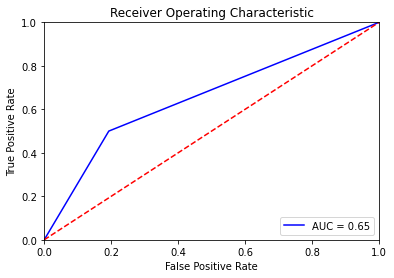

In [78]:
preds = predictProbTest[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = {}'.format(round(roc_auc,2)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [79]:
threshold = calculate_threshold(dtree, X_test, y_test)
threshold

Area under the ROC curve : 0.653509


1.0

## Tree Visualization

Scikit learn actually has some built-in visualization capabilities for decision trees, you won't use this often and it requires you to install the pydot library, but here is an example of what it looks like and the code to execute this:

In [80]:
from IPython.display import Image  
from six import StringIO
from sklearn import tree
from sklearn.tree import export_graphviz
import pydot 

features = list(df.columns[1:])
features

['anaemia',
 'creatinine_phosphokinase',
 'diabetes',
 'ejection_fraction',
 'high_blood_pressure',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'sex',
 'smoking',
 'time',
 'DEATH_EVENT']

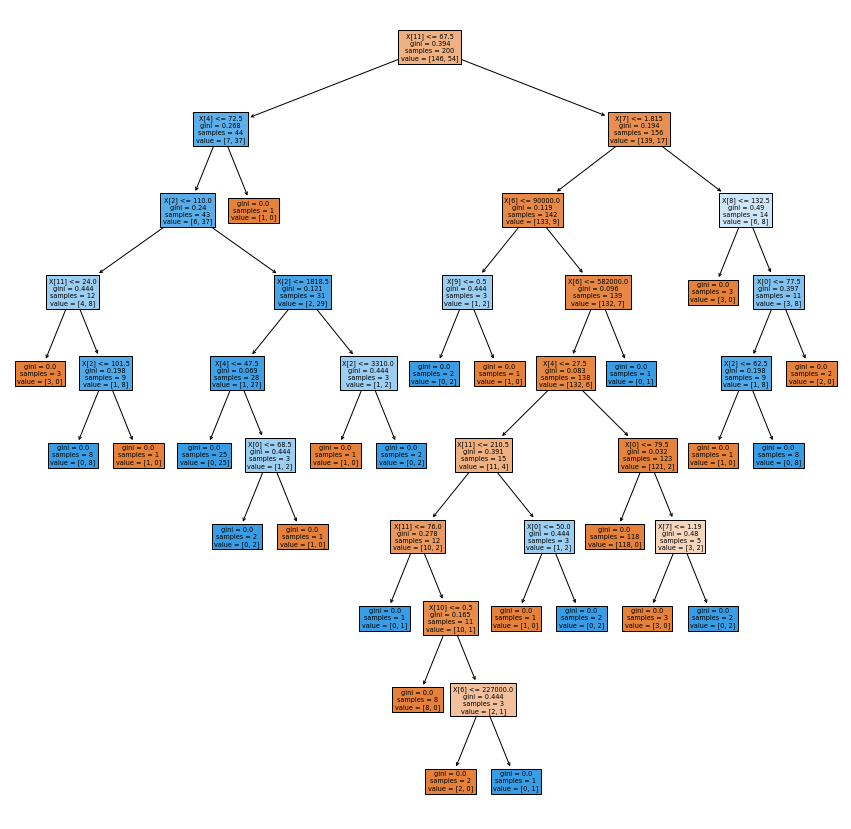

In [81]:
from sklearn import tree
fig,axes = plt.subplots(nrows = 1,ncols = 1, figsize = (15,15))
tree.plot_tree(dtree, filled = True)
fig.savefig('decisiontree_heart_failure.png')